In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

In [2]:
@kwdef struct SaccadeModelParameter
    n = 4 # number of dims
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(3) I(3); -[0, α1, α2, α3]']
    B = [zeros(3); bu]
    C = [I(3) zeros(3)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)

    Q = Diagonal([1.0, 0.01, 0, 0]) 
    R = 0.0001
    U = Diagonal([1.0, 0.1, 0.01, 0])
end

SaccadeModelParameter

In [3]:
function infinite_horizon_ofc(param::SaccadeModelParameter, maxiter=1000, ϵ=1e-8)
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    
    # initialize
    L = rand(n)' # Feedback gains
    K = rand(n, 3) # Kalman gains
    I₂ₙ = I(2n)

    for _ in 1:maxiter
        Ā = [A-B*L B*L; zeros(size(A)) (A-K*C)]
        Ȳ = [-ones(2) ones(2)] ⊗ (Y*L) 
        Ḡ = [G zeros(size(K)); G (-K*D)]
        V = BlockDiagonal([Q, U]) + [1 -1; -1 1] ⊗ (L'* R * L)

        # update S, P
        S = -reshape((I₂ₙ ⊗ (Ā)' +  (Ā)' ⊗ I₂ₙ + (Ȳ)' ⊗ (Ȳ)') \ vec(V), (2n, 2n))
        P = -reshape((I₂ₙ ⊗ Ā +  Ā ⊗ I₂ₙ + Ȳ ⊗  Ȳ) \ vec(Ḡ * (Ḡ)'), (2n, 2n))

        # update K, L
        P₂₂ = P[n+1:2n, n+1:2n]
        S₁₁ = S[1:n, 1:n]
        S₂₂ = S[n+1:2n, n+1:2n]

        Kₜ₋₁ = copy(K)
        Lₜ₋₁ = copy(L)

        K = P₂₂ * C' / (D * D')
        L = (R + Y' * (S₁₁ + S₂₂) * Y) \ B' * S₁₁
        if sum(abs.(K - Kₜ₋₁)) < ϵ && sum(abs.(L - Lₜ₋₁)) < ϵ
            break
        end
    end
    return L, K
end

infinite_horizon_ofc (generic function with 3 methods)

In [4]:
param = SaccadeModelParameter()
L, K = infinite_horizon_ofc(param);

In [5]:
function simulation(param::SaccadeModelParameter, L, K, dt=0.001, T=2.0, init_pos=-0.5; noisy=true)
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    nt = round(Int, T/dt)
    X = zeros(n, nt)
    u = zeros(nt)
    X[1, 1] = init_pos # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            u[t] = -L * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            u[t] = -L * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    return X, u
end

simulation (generic function with 4 methods)

In [6]:
dt = 1e-3
T = 1.0

1.0

In [7]:
Xa, ua = simulation(param, L, K, dt, T, noisy=false);

In [8]:
n = 4
nsim = 10
XSimAll = []
uSimAll = []
for i in 1:nsim
    XSim, u = simulation(param, L, K, dt, T, noisy=true);
    push!(XSimAll, XSim)
    push!(uSimAll, u)
end

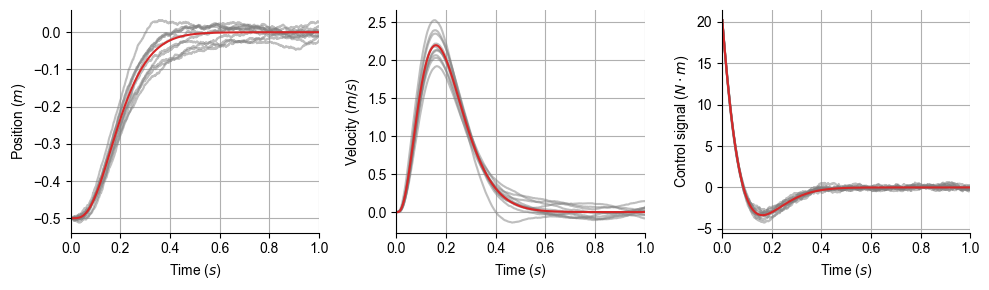

In [9]:
tarray = collect(dt:dt:T)
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

fig, ax = subplots(1, 3, figsize=(10, 3))
for i in 1:2
    for j in 1:nsim
        ax[i].plot(tarray, XSimAll[j][i,:]', "tab:gray", alpha=0.5)
    end
    
    ax[i].plot(tarray, Xa[i,:], "tab:red")
    ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); ax[i].set_xlim(0, T); ax[i].grid()
end

for j in 1:nsim
    ax[3].plot(tarray, uSimAll[j], "tab:gray", alpha=0.5)
end
ax[3].plot(tarray, ua, "tab:red")
ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); ax[3].set_xlim(0, T); ax[3].grid()

tight_layout()

In [10]:
function target_jump_simulation(param::SaccadeModelParameter, L, K, dt=0.001, T=2.0, 
        Ttj=0.4, tj_dist=0.1, 
        init_pos=-0.5; noisy=true)
    # Ttj : target jumping timing (sec)
    # tj_dist : target jump distance
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    nt = round(Int, T/dt)
    ntj = round(Int, Ttj/dt)
    X = zeros(n, nt)
    u = zeros(nt)
    X[1, 1] = init_pos # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            if t == ntj
                X[1, t] -= tj_dist # When k == ntj, target jumpさせる（実際には現在の位置をずらす）
                X̂[1, t] -= tj_dist
            end
            u[t] = -L * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            if t == ntj
                X[1, t] -= tj_dist # When k == ntj, target jumpさせる（実際には現在の位置をずらす）
            end
            u[t] = -L * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    X[1, 1:ntj-1] .-= tj_dist;
    return X, u
end

target_jump_simulation (generic function with 6 methods)

In [11]:
Ttj = 0.4
tj_dist = 0.1
nt = round(Int, T/dt)
ntj = round(Int, Ttj/dt);

In [12]:
Xtj, utj = target_jump_simulation(param, L, K, dt, T, noisy=false);

In [13]:
XtjAll = []
utjAll = []
for i in 1:nsim
    XSim, u = target_jump_simulation(param, L, K, dt, T, noisy=true);
    push!(XtjAll, XSim)
    push!(utjAll, u)
end

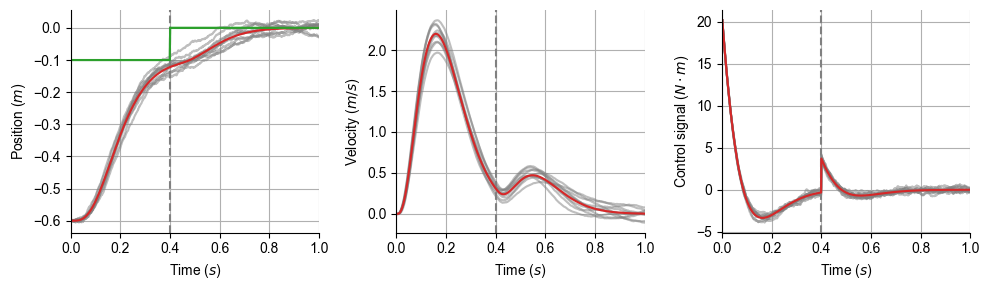

In [14]:
target_pos = zeros(nt)
target_pos[1:ntj-1] .-= tj_dist; 

fig, ax = subplots(1, 3, figsize=(10, 3))
for i in 1:2
    ax[1].plot(tarray, target_pos, "tab:green")
    for j in 1:nsim
        ax[i].plot(tarray, XtjAll[j][i,:]', "tab:gray", alpha=0.5)
    end
    ax[i].axvline(x=Ttj, color="gray", linestyle="dashed")
    ax[i].plot(tarray, Xtj[i,:], "tab:red")
    ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); ax[i].set_xlim(0, T); ax[i].grid()
end
for j in 1:nsim
    ax[3].plot(tarray, utjAll[j], "tab:gray", alpha=0.5)
end
ax[3].axvline(x=Ttj, color="gray", linestyle="dashed")
ax[3].plot(tarray, utj, "tab:red")
ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); ax[3].set_xlim(0, T); ax[3].grid()

tight_layout()